<a href="https://colab.research.google.com/github/bornokhan/Thesis-Final-Code/blob/main/thesis_final_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1PZlMKqtQ1vlURqGx0NBtoQ8yb2RTjuAy'}) # replace the id with id of file you want to access
downloaded.GetContentFile('oasis_longitudinal.csv')

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#DataSet load
df = pd.read_csv('oasis_longitudinal.csv')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [ ]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
#prepossessing
df = df.loc[df['Visit']==1]
df = df.reset_index(drop=True)
df['M/F'] = df['M/F'].replace(['F','M'], [0,1])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented','Converted'], [1,0,1])
df.head()
df = df.drop(['Subject ID','MRI ID','Hand', 'Visit','MR Delay'], axis=1)
df[df==np.inf]=np.nan
df.fillna(df.mean(), inplace=True)

x = df.iloc[:,1:11]  #independent columns

y = df.iloc[:,0]  #target coloum

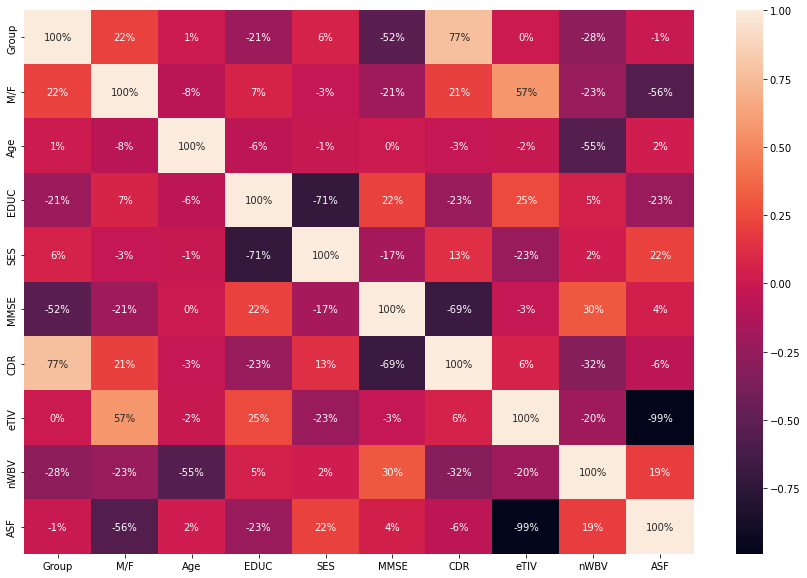

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.iloc[1:,0:10].corr(), annot=True,fmt=".0%")
plt.show()

   Name      value
5   CDR  36.000000
4  MMSE  12.850211
0   M/F   3.891232
2  EDUC   3.821454
6  eTIV   1.116436
3   SES   0.323267
7  nWBV   0.019006
1   Age   0.000476
8   ASF   0.000247
Heatmap of Features 


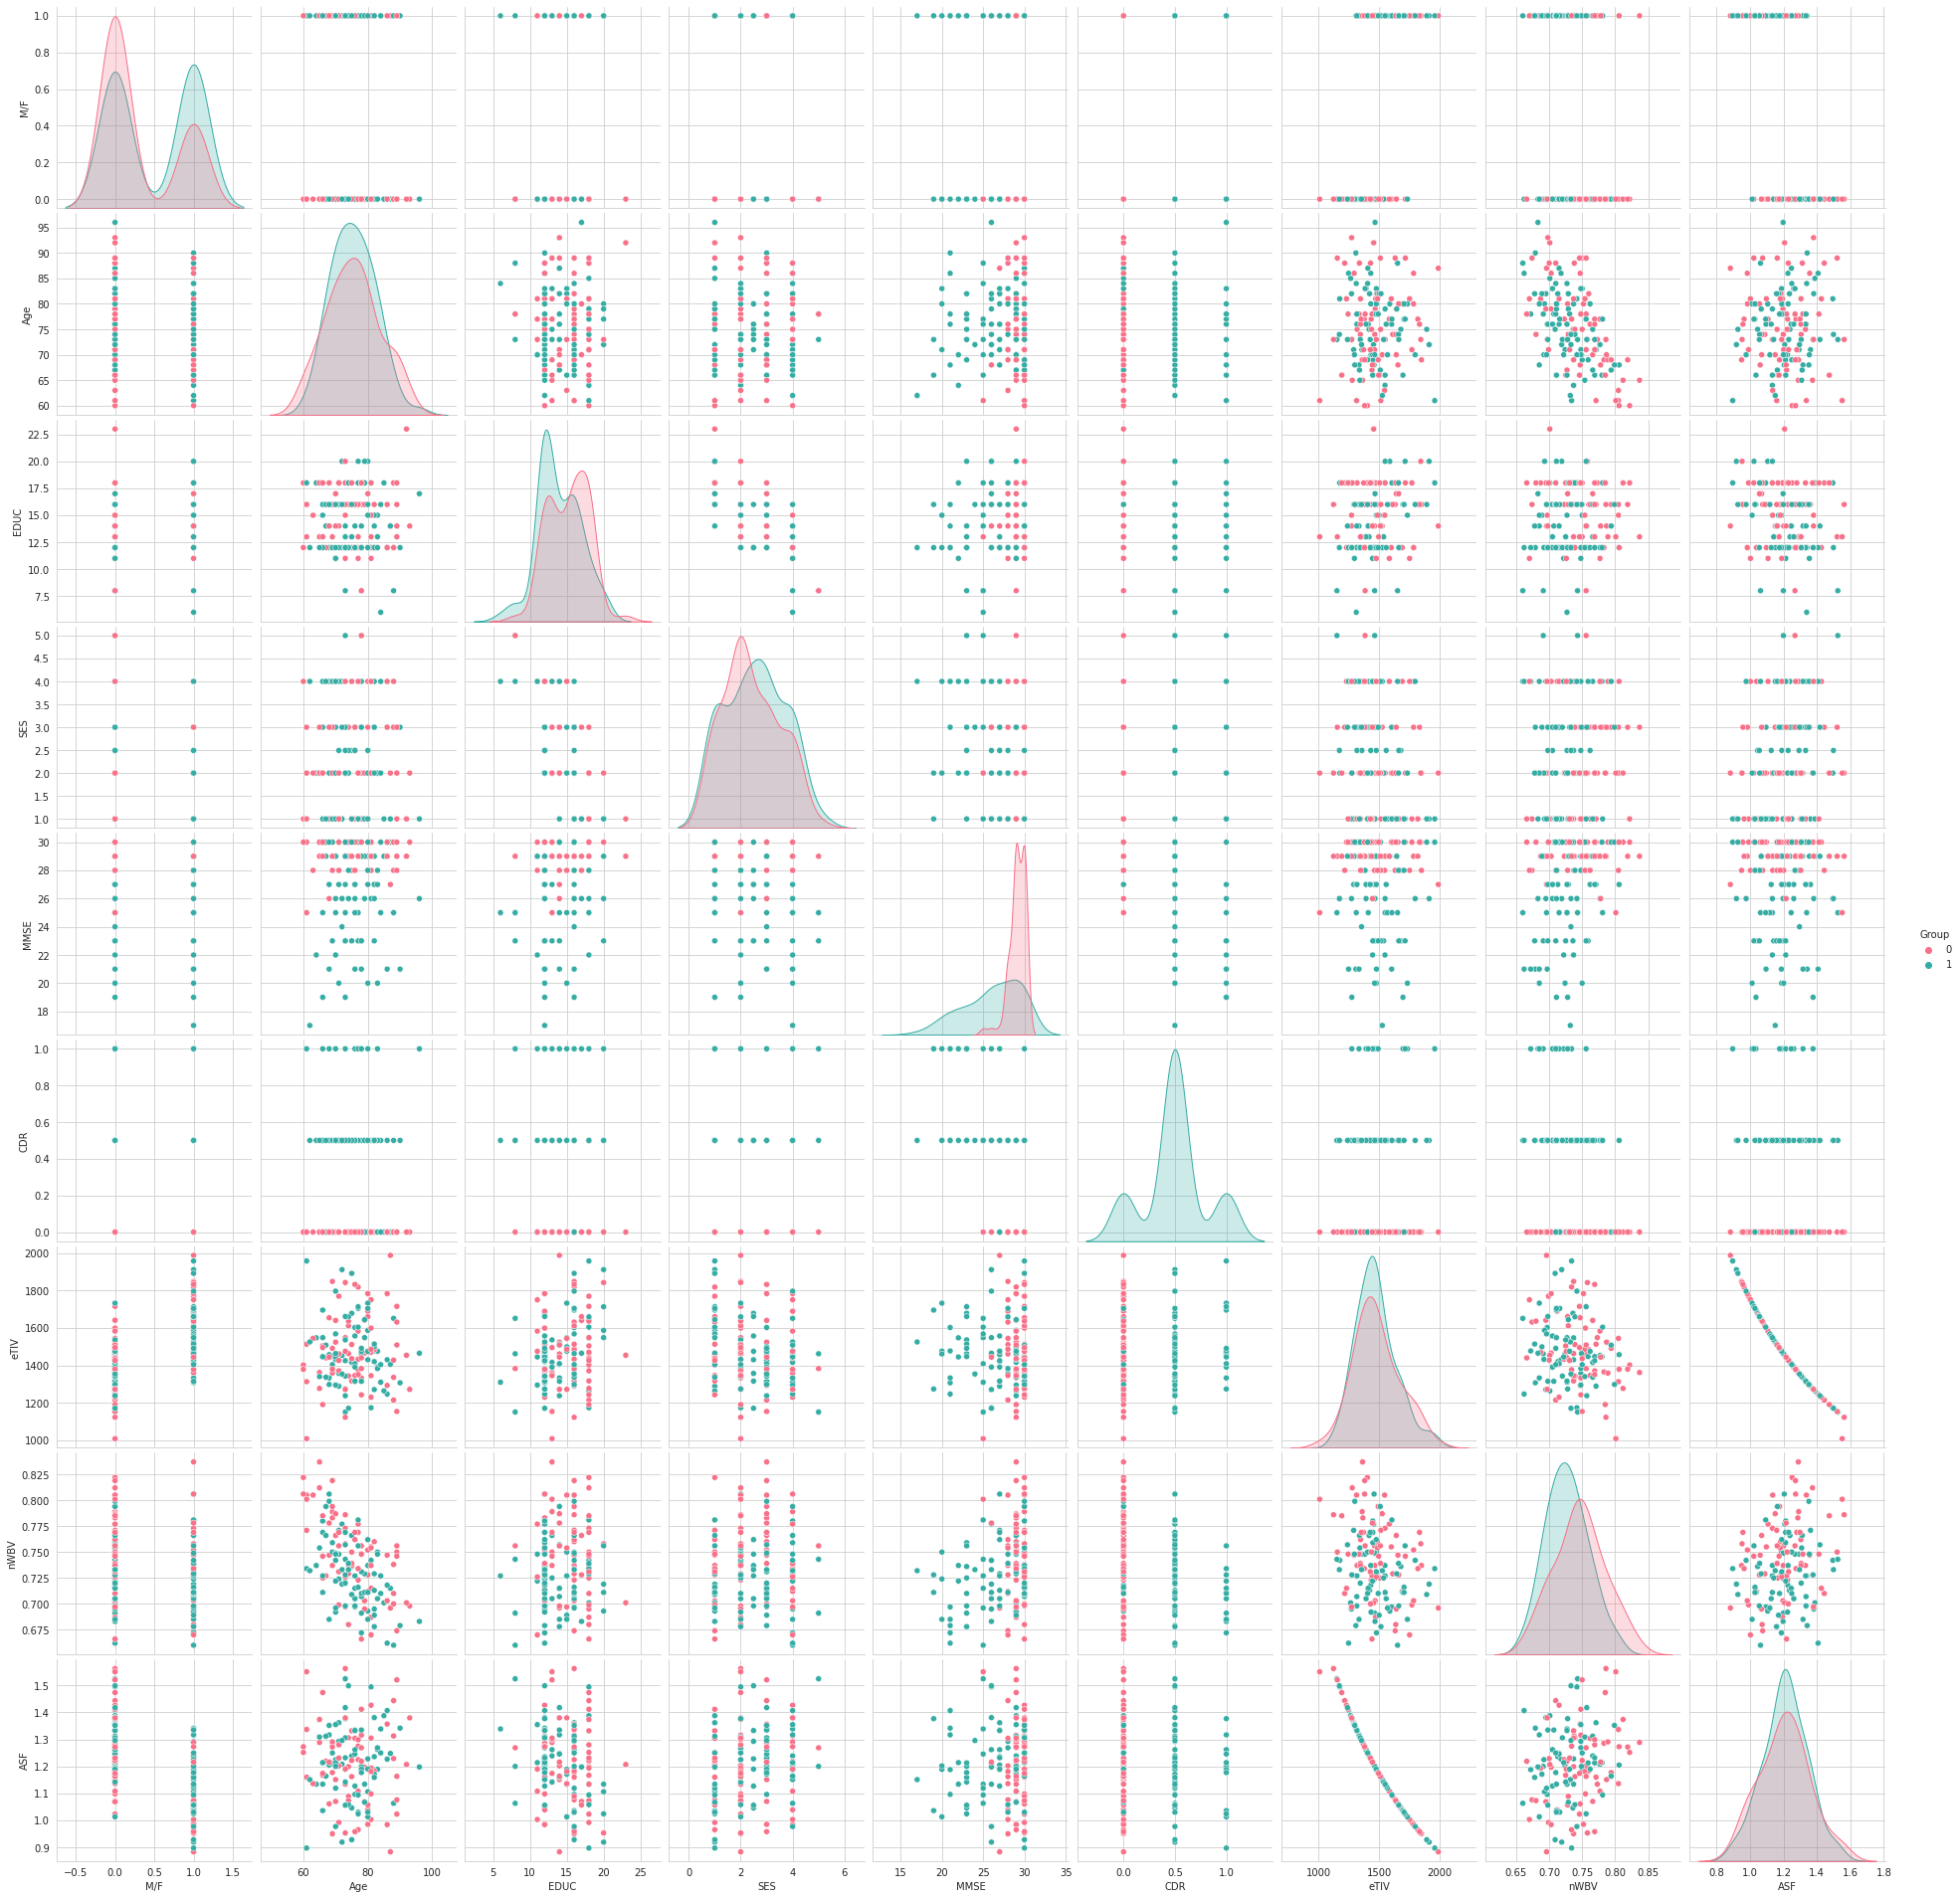

In [ ]:
#Feature
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Name','value']  #naming the dataframe columns
print(featureScores.nlargest(11,'value'))  #print 11 best features
print("Heatmap of Features ")
plt.close();
sns.set_style("whitegrid");
sns.pairplot(df, hue="Group", palette="husl", height=3);
plt.show()

## SVM

In [ ]:
#SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, classification_report



In [ ]:
#Split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(x, y,test_size=0.30,random_state=321)

#Feature Scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Model

best_score = 0
kfolds=5
acc = []
c_c=list(np.arange(0.00001,10,0.5))
g_g=list(np.arange(0.001,12,0.5))
for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']:
    for c_paramter in c_c:
        for gamma_paramter in g_g:

             svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter)
             scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
             score = np.mean(scores)

             if score > best_score:
                best_score = score
                best_parameter_c = c_paramter
                best_parameter_gamma = gamma_paramter
                best_parameter_k = k_parameter

SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("HyperParameter Tuning Results")
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test AUC with the best parameter is", test_auc)
m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

#Confusion matrix
ccm = confusion_matrix(Y_test,PredictedOutput)
print ('Confusion Matrix :')
print(ccm)
print ('Accuracy Score :',accuracy_score(Y_test,PredictedOutput))
print ('Report : ')
print (classification_report(Y_test,PredictedOutput))

HyperParameter Tuning Results
Best accuracy on cross validation set is: 0.9142857142857143
Best parameter for c is:  7.000009999999999
Best parameter for gamma is:  1.001
Best parameter for kernel is:  sigmoid
Test accuracy with the best parameters is 0.8666666666666667
Test recall with the best parameters is 0.8260869565217391
Test AUC with the best parameter is 0.8675889328063241
Confusion Matrix :
[[20  2]
 [ 4 19]]
Accuracy Score : 0.8666666666666667
Report : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.90      0.83      0.86        23

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45



# Navie Bayes

In [ ]:
#navie bayes
from sklearn.naive_bayes import  GaussianNB

# Create a GaussianNB Classifier
gnb = GaussianNB(priors=None, var_smoothing=1e-09)


# Train the model using the training sets
gnb.fit(X_trainval_scaled,Y_trainval)

#Predict the response for test dataset
y_pred = gnb.predict(X_test_scaled)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

acc=accuracy_score(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print('Accuracy Score :',acc)

[[22  0]
 [ 3 20]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.87      0.93        23

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45

Accuracy Score : 0.9333333333333333


# ANN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras import layers

In [ ]:
#ann
Y_train_n = Y_trainval
Y_test_n  = Y_test

X_train_n = X_trainval_scaled
X_test_n  = X_test_scaled

In [ ]:
# init NN

pp=Sequential()

#Adding input layer and first hidden layer
pp.add(layers.Dense(13, activation ='relu', input_dim=9))
pp.add(Dropout(0.2))

# adding second hidden layer
pp.add(layers.Dense( 18,  activation ='relu'))
pp.add(Dropout(0.2))

pp.add(layers.Dense( 5 ,activation ='relu'))
pp.add(Dropout(0.2))
# adding output layer
pp.add(layers.Dense( 1, activation='sigmoid'))




In [ ]:
#compling the nn
pp.compile(optimizer='Adam', loss='binary_crossentropy', metrics =['accuracy'])


# fitting the model
y=pp.fit(X_train_n,Y_train_n,batch_size = 10,epochs  =300)

#predicting the test set result
y_pred=pp.predict(X_test_n)
y_pred=(y_pred >0.5)


print(pp.summary())


Epoch 1/300
11/11 [==============================] - 1s 2ms/step - loss: 0.7331 - accuracy: 0.4952
Epoch 2/300
11/11 [==============================] - 0s 2ms/step - loss: 0.7163 - accuracy: 0.5143
Epoch 3/300
11/11 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.4952
Epoch 4/300
11/11 [==============================] - 0s 2ms/step - loss: 0.7262 - accuracy: 0.3714
Epoch 5/300
11/11 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.5048
Epoch 6/300
11/11 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.5143
Epoch 7/300
11/11 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5524
Epoch 8/300
11/11 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5238
Epoch 9/300
11/11 [==============================] - 0s 2ms/step - loss: 0.6679 - accuracy: 0.5619
Epoch 10/300
11/11 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4857
Epoch 11/

In [ ]:
# creating the confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(Y_test_n,y_pred)
print ('Confusion Matrix :')
print(cm)
print ('Accuracy Score :',accuracy_score(Y_test_n,y_pred))
print ('Report : ')
print (classification_report(Y_test_n,y_pred))

Confusion Matrix :
[[22  0]
 [ 3 20]]
Accuracy Score : 0.9333333333333333
Report : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.87      0.93        23

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



# **1-DCNN**



In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
import tensorflow as tf

In [ ]:
#cnn
Y_train_cnn = Y_trainval
Y_test_cnn  = Y_test

X_train_cnn = X_trainval_scaled
X_test_cnn  = X_test_scaled
num_classes=2

In [ ]:
X_train_cnn = np.array(X_train_cnn).reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_train_cnn.shape
print(X_train_cnn.shape)

(105, 9, 1)


In [ ]:
X_train_cnn.shape[1]

9

In [ ]:

model = Sequential()
model.add(Convolution1D(128, kernel_size=3,padding = 'same' ,activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Convolution1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(optimizer='adam',loss=tf.losses.sparse_categorical_crossentropy,metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 128)            512       
                                                                 
 batch_normalization (BatchN  (None, 9, 128)           512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 128)            49280     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 128)           512       
 hNormalization)                                                 
                                                      

In [ ]:
#model.compile(optimizer='adam',loss=tf.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
#print(X_train.shape)
#print(y_train.shape)

In [ ]:
y_pre = model.fit(X_train_cnn,Y_train_cnn, batch_size=10, epochs=500, verbose=0)
y_pre=model.predict(X_test_cnn)
y_pre = y_pre[:, 1]
y_pre=(y_pre>.5)

In [ ]:
#(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cm = confusion_matrix(Y_test_cnn,y_pre)
accuracy_score(Y_test_cnn,y_pre)
print(classification_report(Y_test_cnn,y_pre))
print ('Confusion Matrix :')
print(cm)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        22
           1       0.90      0.78      0.84        23

    accuracy                           0.84        45
   macro avg       0.85      0.85      0.84        45
weighted avg       0.85      0.84      0.84        45

Confusion Matrix :
[[20  2]
 [ 5 18]]


In [ ]:
pip install mlxtend


In [ ]:
#!apt install libnvrtc8.0
#!pip install mxnet-cu80

In [ ]:
!pip install six

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Accuracy on cross validation using 5 flods : 0.91 (+/- 0.07) [SVM]
Accuracy on cross validation using 5 flods : 0.90 (+/- 0.05) [NB]
Accuracy on cross validation using 5 flods : 0.79 (+/- 0.14) [ANN]
Accuracy on cross validation using 5 flods : 0.83 (+/- 0.07) [keras_clf]
Accuracy on cross validation using 5 flods : 0.90 (+/- 0.05) [Ensemble]
Confusion Matrix For Proposed Model:
[[22  0]
 [ 3 20]]
Accuracy Score : 0.9333333333333333
Report : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.87      0.93        23

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



Text(0.5, 1.0, 'Confusion Matrix')

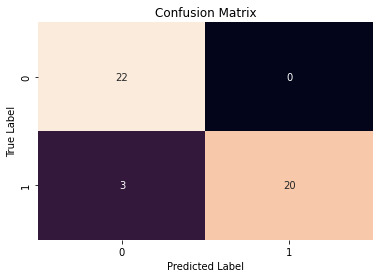

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.base import clone

from keras.models import Sequential, Model
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mlxtend.classifier import EnsembleVoteClassifier
from keras.models import sequential
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, classification_report
import tensorflow as tf


X_train_en = X_trainval_scaled
X_test_en  = X_test_scaled
Y_train_en = Y_trainval
Y_test_en  = Y_test


en_svm = SVC(C=7.000009999999999, gamma= 1.001, kernel='sigmoid')
en_nv = GaussianNB(priors=None, var_smoothing=1e-09)

en_ann = MLPClassifier(activation='relu',hidden_layer_sizes=(13,18,5), solver='adam',batch_size=10,learning_rate='constant',learning_rate_init=0.01, max_iter=500, tol=0.0001 )
# Keras Model
num_classes=2
def build_1dcnn():
  model = Sequential()
  model.add(Convolution1D(128, kernel_size=3,padding = 'same' ,activation='relu', input_shape=(X_train_en.shape[1], 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Convolution1D(128,kernel_size=3,padding = 'same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=(2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer='adam',loss=tf.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
  return model
keras_clf =tf.keras.wrappers.scikit_learn.KerasClassifier( build_1dcnn, batch_size=10 ,epochs=500, verbose=False)
keras_clf._estimator_type = "classifier"

# create the ensemble model

eclf = EnsembleVoteClassifier(clfs=[en_svm,en_nv, en_ann,keras_clf],voting = 'hard')

labels = ['SVM', 'NB','ANN','keras_clf', 'Ensemble']
for clf, label in zip([en_svm,en_nv, en_ann,keras_clf, eclf], labels):

     #validation performance
    scores = cross_val_score(clf, X_train_en, Y_train_en, cv=5, scoring='accuracy')

    print("Accuracy on cross validation using 5 flods : %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


#Ensemble or Proposed model
En_model_prop = eclf.fit(X_train_en, Y_train_en)
p_prop = En_model_prop.predict(X_test_en)
cm_en_prop = confusion_matrix(Y_test_en,p_prop)
print ('Confusion Matrix For Proposed Model:')
print (cm_en_prop)
print ('Accuracy Score :',accuracy_score(Y_test_en,p_prop))
print ('Report : ')
print (classification_report(Y_test_en,p_prop))
sns.heatmap(cm_en_prop,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')